<a href="https://colab.research.google.com/github/MeghaPujamath/Reinforcement-Learning---DQN-for-cartpole-environment-/blob/main/DQN_for_Cartpole_Env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all libraries**

In [125]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

**Hyper-parameters Initialization**

In [126]:
batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100

**Environment Settings**

In [127]:
env = gym.make('CartPole-v0')
memory = deque(maxlen=buffer_size)
reward_buffer = deque()

state_size = env.observation_space.shape
action_size = env.action_space.n

**Neural Network Class Implementation**

In [128]:
class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(nn.Linear(input_features, 64), nn.Tanh(), nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)

  def act(self, state):
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action

**Initializing Networks**

In [129]:
main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)

**Defining Replay Buffer Class**

In [131]:
class ReplayBuffer:
  def __init__(self, buffer_size=buffer_size):
    self.buffer_size = buffer_size
    self.buffer = deque(maxlen=self.buffer_size)
  
  def insert_replayBuffer(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))
  
  def sample_replayBuffer(self, batch_size):
    return random.sample(self.buffer, batch_size)
  
  def buffer_initialization(self, env, min_replay_size):
    state = env.reset()
    for _ in range(min_replay_size):
      action = env.action_space.sample()
      next_state, reward, done, _ = env.step(action)
      self.insert_replayBuffer(state, action, reward, next_state, done)

      state = next_state
      if done:
        state = env.reset()

**Replay Buffer Training Function**

In [132]:
def ReplayBufferLearn(batch_size, minibatch):
    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])

    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    #Actual q values or ground truth from target network using next state
    target_q_values = target_net(next_states_t) 
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
    # test = torch.tensor(targets, requires_grad=True)

    #Predicted q values from main network using current state
    q_values = main_net(states_t)
    # action_q_values, _ = torch.max(q_values, axis=1)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
    # test2 = torch.tensor(action_q_values, requires_grad=True)

    #Compute Losses
    # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    loss = torch.nn.MSELoss()(action_q_values, targets)

    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Training Loop

In [ ]:
rb = ReplayBuffer()
rb.buffer_initialization(env, min_replay_size)
episode_reward = 0.0
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
loss_test = []
loss_test2 = []
losses = 0
state = env.reset()
steps = 0
epis_len = 0
for e in itertools.count():
  epis_len += 1
  epsi = np.interp(e, [0, epsilonFactor], [epsilon, minEpsilon])
  if random.random() <= epsi:
    action = env.action_space.sample() #random action selection i.e exploring
  else:
    action = main_net.act(state)

  next_state, reward, done, _ = env.step(action)
  memory.append((state, action, reward, next_state, done))

  state = next_state
  episode_reward += reward
  if done:
    steps += 1
    state = env.reset()
    reward_buffer.append(episode_reward)
    
    losses_list.append(losses/epis_len)

    print(f'At Episode {steps} with Reward {episode_reward} and Average Reward {np.mean(reward_buffer)}')
    episode_reward = 0.0
    epis_len = 0

  miniBatch = rb.sample_replayBuffer(batch_size)
  loss = ReplayBufferLearn(batch_size, miniBatch)
  losses += loss

  #Update the Target Network
  if e % target_update_fre== 0:
    target_net.load_state_dict(main_net.state_dict())
  
  epsilon_list.append(epsi)
  
  if(len(reward_buffer) > 700):
    break

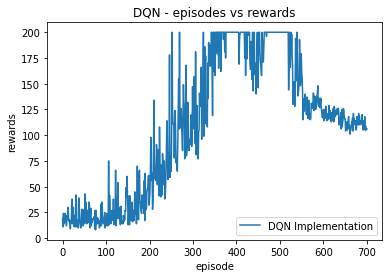

In [134]:
fig, ax = plt.subplots()
plt.title('DQN - episodes vs rewards')
plt.plot(reward_buffer, label='DQN Implementation')
plt.xlabel("episode")
plt.ylabel("rewards")
plt.legend()
plt.show()

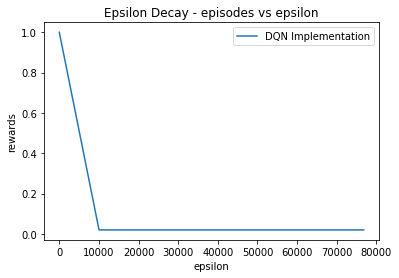

In [135]:
fig, ax = plt.subplots()
plt.title('Epsilon Decay - episodes vs epsilon')
plt.plot(epsilon_list, label='DQN Implementation')
plt.xlabel("epsilon")
plt.ylabel("rewards")
plt.legend()
plt.show()